# Dataset analysis
Understanding the data is essential part of creating models that perform well. We can understand data through data analysis.

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf

In [27]:
df = pd.read_csv('dataset.csv')
df.head()

,PM10 Concentration,PM10 Unit,DatetimeBegin,DatetimeEnd,PM2.5 Concentration,PM2.5 Unit,CO Concentration,CO Unit,NO2 Concentration,NO2 Unit
0,38.942,µg/m3,2018-01-01 00:00:00 +01:00,2018-01-01 01:00:00 +01:00,46.409,µg/m3,0.46168,mg/m3,21.6056,µg/m3
1,52.889,µg/m3,2018-01-01 01:00:00 +01:00,2018-01-01 02:00:00 +01:00,53.467,µg/m3,0.43268,mg/m3,21.1869,µg/m3
2,37.007,µg/m3,2018-01-01 02:00:00 +01:00,2018-01-01 03:00:00 +01:00,37.668,µg/m3,0.39208,mg/m3,16.2845,µg/m3
3,35.837,µg/m3,2018-01-01 03:00:00 +01:00,2018-01-01 04:00:00 +01:00,37.333,µg/m3,0.38628,mg/m3,17.3246,µg/m3
4,34.408,µg/m3,2018-01-01 04:00:00 +01:00,2018-01-01 05:00:00 +01:00,29.130,µg/m3,0.36308,mg/m3,15.5656,µg/m3


In [28]:
print(f'Number of rows: {len(df)}')

Number of rows: 26298


In [29]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM10 Concentration,25956.0,22.392300,14.358808,0.00260,12.415750,19.768500,28.975500,353.12000
PM2.5 Concentration,25728.0,14.541749,12.478324,0.01220,5.852625,10.847500,19.669000,118.52000
CO Concentration,25640.0,0.384108,0.165666,0.04176,0.265060,0.344636,0.467016,3.29904
NO2 Concentration,25650.0,31.520344,20.845578,1.10093,15.093450,27.236400,43.630850,145.59900


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

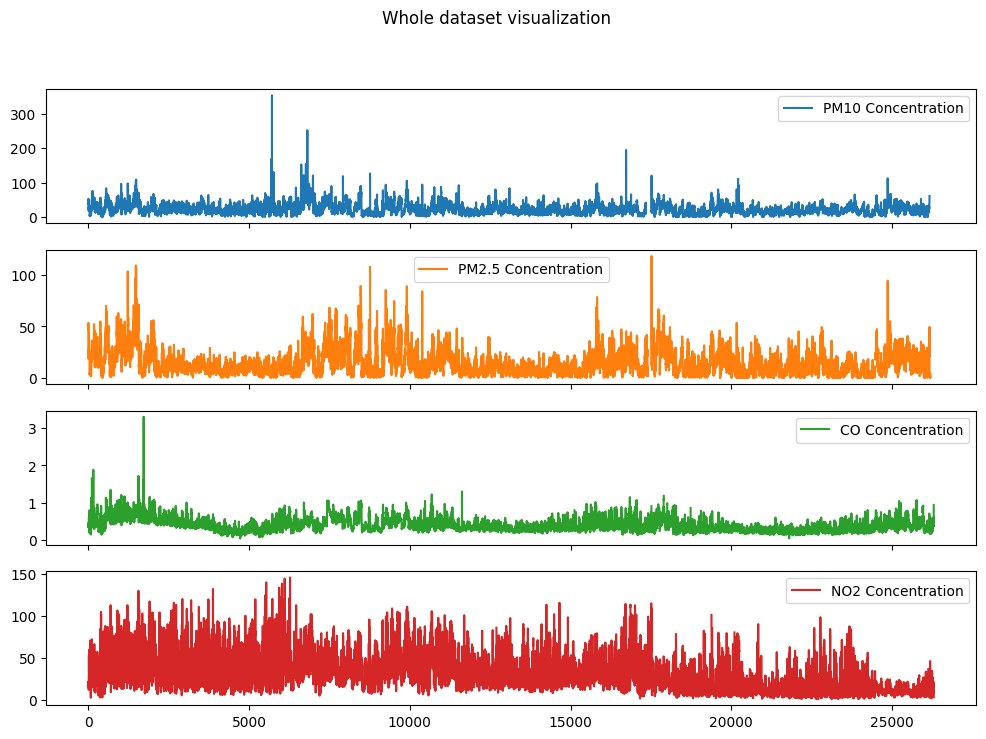

In [30]:
df.plot(subplots=True, title='Whole dataset visualization')

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

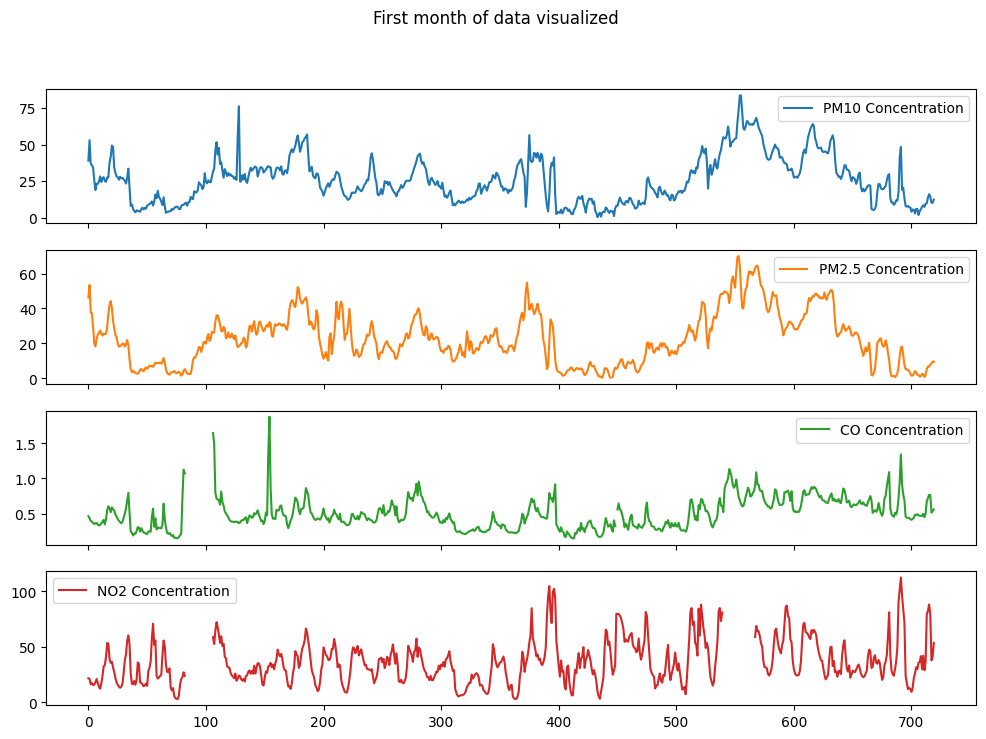

In [31]:
df[:720].plot(subplots=True, title='First month of data visualized')

c:\Users\Gamebox\Desktop\School\FIIT\BP_time_series_forecasting_cambals\BP_env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

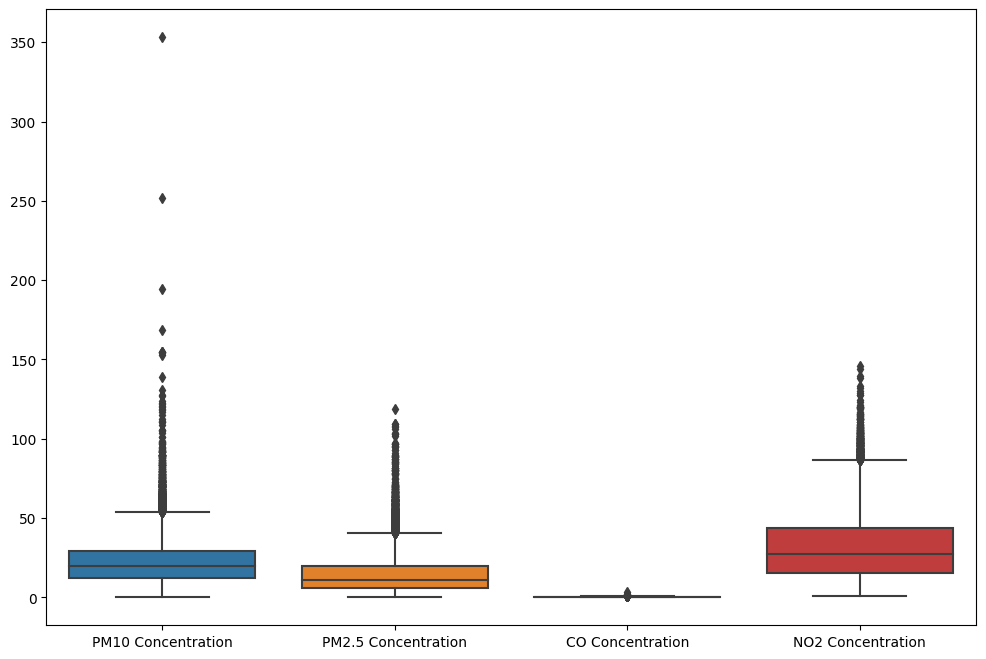

In [32]:
sns.boxplot(data=df)

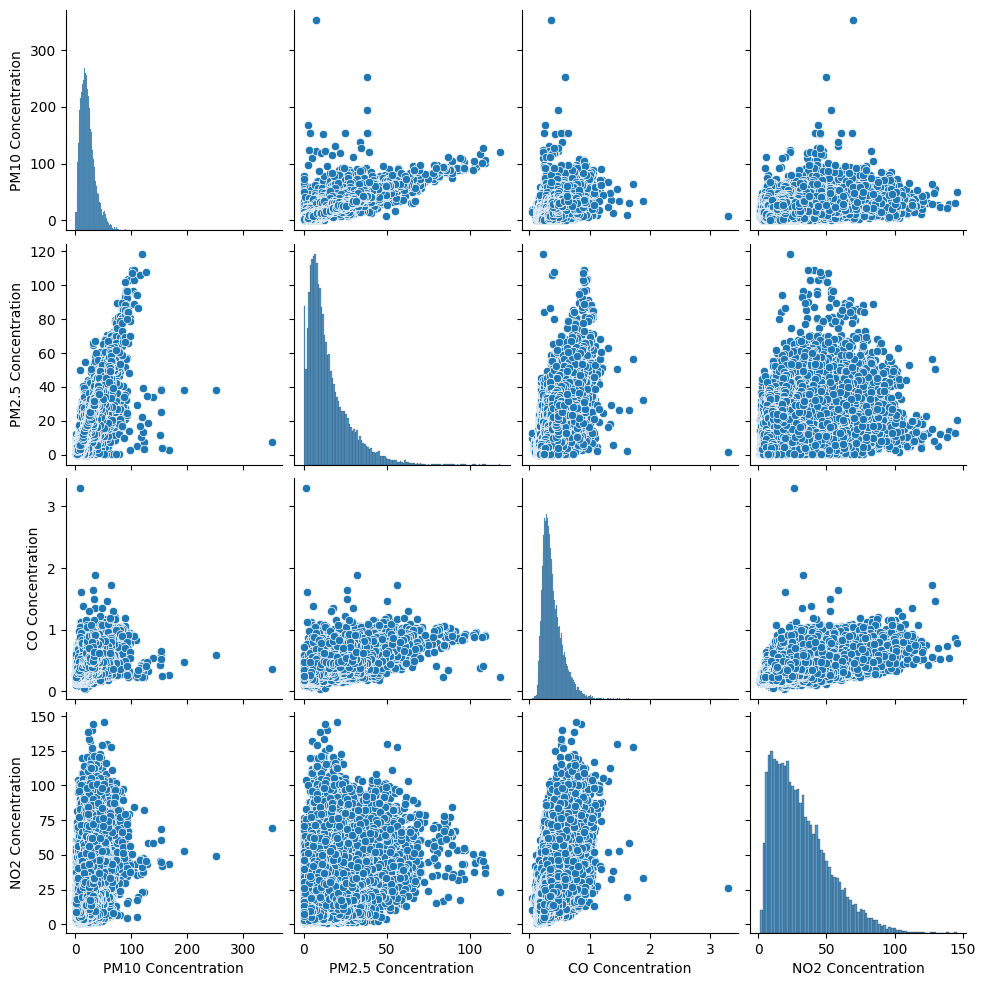

In [33]:
sns.pairplot(data=df)

In [34]:
df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']].corr(method='pearson')

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration
PM10 Concentration,1.000000,0.791429,0.517186,0.340900
PM2.5 Concentration,0.791429,1.000000,0.614492,0.238039
CO Concentration,0.517186,0.614492,1.000000,0.602560
NO2 Concentration,0.340900,0.238039,0.602560,1.000000


<AxesSubplot: >

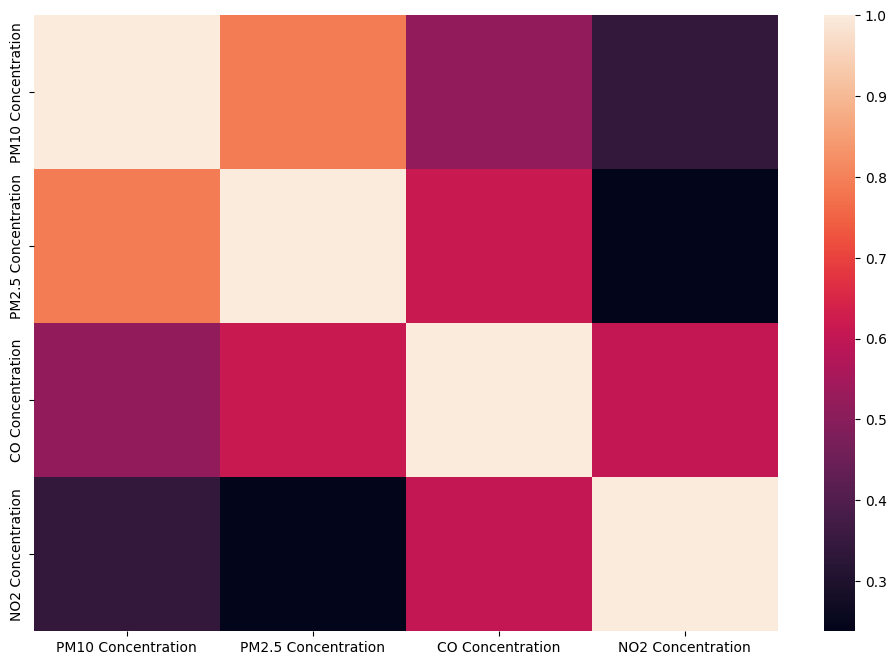

In [35]:
sns.heatmap(data=df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']].corr(method='pearson'))

The table shows that correlation coefficient between any pair of measured data is considerably strong. This means our data is related. We can see particularly strong correlation between PM10 and PM2.5 particles and PM2.5 particles and CO concentration.

In [36]:
nan_rows = sum(df.apply(lambda x: sum(x.isnull().values), axis = 1) > 0)
print(f'Number of rows containing NaN is {nan_rows}/{len(df)} or {round(nan_rows / len(df) * 100, 3)} %')

Number of rows containing NaN is 1752/26298 or 6.662 %


In [37]:
df[df.isna().any(axis = 1)]

,PM10 Concentration,PM10 Unit,DatetimeBegin,DatetimeEnd,PM2.5 Concentration,PM2.5 Unit,CO Concentration,CO Unit,NO2 Concentration,NO2 Unit
83,10.3570,µg/m3,2018-01-04 11:00:00 +01:00,2018-01-04 12:00:00 +01:00,4.0930,µg/m3,NaN,NaN,NaN,NaN
84,8.2579,µg/m3,2018-01-04 12:00:00 +01:00,2018-01-04 13:00:00 +01:00,2.8066,µg/m3,NaN,NaN,NaN,NaN
85,10.6530,µg/m3,2018-01-04 13:00:00 +01:00,2018-01-04 14:00:00 +01:00,2.6694,µg/m3,NaN,NaN,NaN,NaN
86,10.7530,µg/m3,2018-01-04 14:00:00 +01:00,2018-01-04 15:00:00 +01:00,2.4226,µg/m3,NaN,NaN,NaN,NaN
87,14.2640,µg/m3,2018-01-04 15:00:00 +01:00,2018-01-04 16:00:00 +01:00,2.5806,µg/m3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
26293,NaN,NaN,2020-12-17 14:00:00 +01:00,2020-12-17 15:00:00 +01:00,NaN,NaN,0.484880,mg/m3,NaN,NaN
26294,NaN,NaN,2020-12-23 13:00:00 +01:00,2020-12-23 14:00:00 +01:00,NaN,NaN,0.938788,mg/m3,NaN,NaN
26295,NaN,NaN,2020-10-04 11:00:00 +01:00,NaN,NaN,NaN,NaN,NaN,3.39476,µg/m3
26296,NaN,NaN,2020-10-19 15:00:00 +01:00,NaN,NaN,NaN,NaN,NaN,21.31880,µg/m3


# Data cleaning

#### Time-series cleaning

In [38]:
def timeCleaning(x):
    return x.rsplit(' ', 1)[0]
df['DatetimeBegin'] = df['DatetimeBegin'].apply(timeCleaning)
df.drop(columns='DatetimeEnd', inplace=True)

#### NaN imputing

In [39]:
df.drop(['PM10 Unit', 'PM2.5 Unit', 'CO Unit', 'NO2 Unit'], inplace=True, axis=1)
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']])
df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']] = imputer.transform(df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']])
df

,PM10 Concentration,DatetimeBegin,PM2.5 Concentration,CO Concentration,NO2 Concentration
0,38.942000,2018-01-01 00:00:00,46.409000,0.461680,21.605600
1,52.889000,2018-01-01 01:00:00,53.467000,0.432680,21.186900
2,37.007000,2018-01-01 02:00:00,37.668000,0.392080,16.284500
3,35.837000,2018-01-01 03:00:00,37.333000,0.386280,17.324600
4,34.408000,2018-01-01 04:00:00,29.130000,0.363080,15.565600
...,...,...,...,...,...
26293,27.015515,2020-12-17 14:00:00,19.257201,0.484880,39.260461
26294,47.561586,2020-12-23 13:00:00,40.458237,0.938788,73.931290
26295,16.045410,2020-10-04 11:00:00,10.640060,0.248890,3.394760
26296,20.097694,2020-10-19 15:00:00,13.094826,0.334342,21.318800


In [40]:
df_timestamps = pd.to_datetime(df.pop('DatetimeBegin'), format='%Y.%m.%d %H:%M:%S')

#### Outlier imputation

c:\Users\Gamebox\Desktop\School\FIIT\BP_time_series_forecasting_cambals\BP_env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

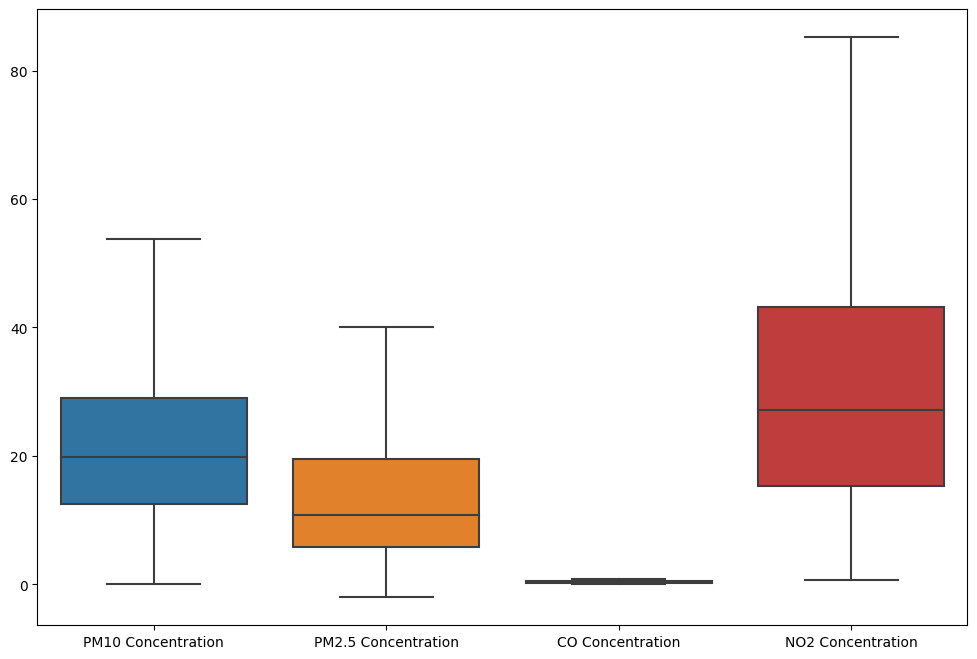

In [41]:
class QuantileOutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def impute(self, data, feature: str):
        # print(f'Imputing outliers for feature: {feature}')
        q25, q75 = np.percentile(data[feature], 25), np.percentile(data[feature], 75)
        iqr = q75 - q25
        # print(f'q25 = {round(q25, 3)}; q75 = {round(q75, 3)}; IQR = {round(iqr, 3)}')
        cutoff = round(iqr * 1.5, 5)
        lower, upper = q25 - cutoff, q75 + cutoff
        # print('cutoff=', round(cutoff, 3), 'lower=', round(lower, 3), 'upper=', round(upper, 3), '\n')
        q5, q95 = np.percentile(data[feature], 5), np.percentile(data[feature], 95)

        outliers_lower = data[feature] <= lower
        data[feature].mask(outliers_lower, other=q5, axis=0, inplace=True)
        outliers_upper = data[feature] >= upper
        data[feature].mask(outliers_upper, other=q95, axis=0, inplace=True)
        return data

    def fit(self, X, y=None):
        self.data = X
        self.features = [x for x in df.columns if x not in ['longitude', 'latitude', 'TEMP', 'PRES', 'warning']]
        return self

    def transform(self, X, y=None):
        cols = [x for x in df.columns if x not in ['longitude', 'latitude', 'TEMP', 'PRES', 'warning']]
        for feature in cols:
            self.data = self.impute(self.data, feature)
        return self.data

outlier_imputer = QuantileOutlierImputer()
df = outlier_imputer.fit_transform(df)
sns.boxplot(data=df)

## Augmented Dickey-Fuller (ADF) unit root test
Augmented Dickey-Fuller (ADF) unit root test is defined as follows:
- $H_0$: the data possesses a unit root (random walk) and it is non-stationary.
- $H_a$: the data is stationary.

Result intepretation:
- if ADF statistic test < 1% 5% 10% (Critical Values) then $H_0$ is rejected
- if P-Value < 0.05 then $H_0$ is rejected 

In [42]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if not missing:
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print(col, '  ADF val: ', dftest[0], '\tp-value: ', dftest[1], '\tNum of lags: ', dftest[2])

PM10 Concentration   ADF val:  -13.101120376922994 	p-value:  1.7090876388708395e-24 	Num of lags:  48
PM2.5 Concentration   ADF val:  -11.312458059667243 	p-value:  1.229434192217937e-20 	Num of lags:  49
CO Concentration   ADF val:  -9.159615186103897 	p-value:  2.5539936901465716e-15 	Num of lags:  49
NO2 Concentration   ADF val:  -9.968923388275813 	p-value:  2.267628471532373e-17 	Num of lags:  49


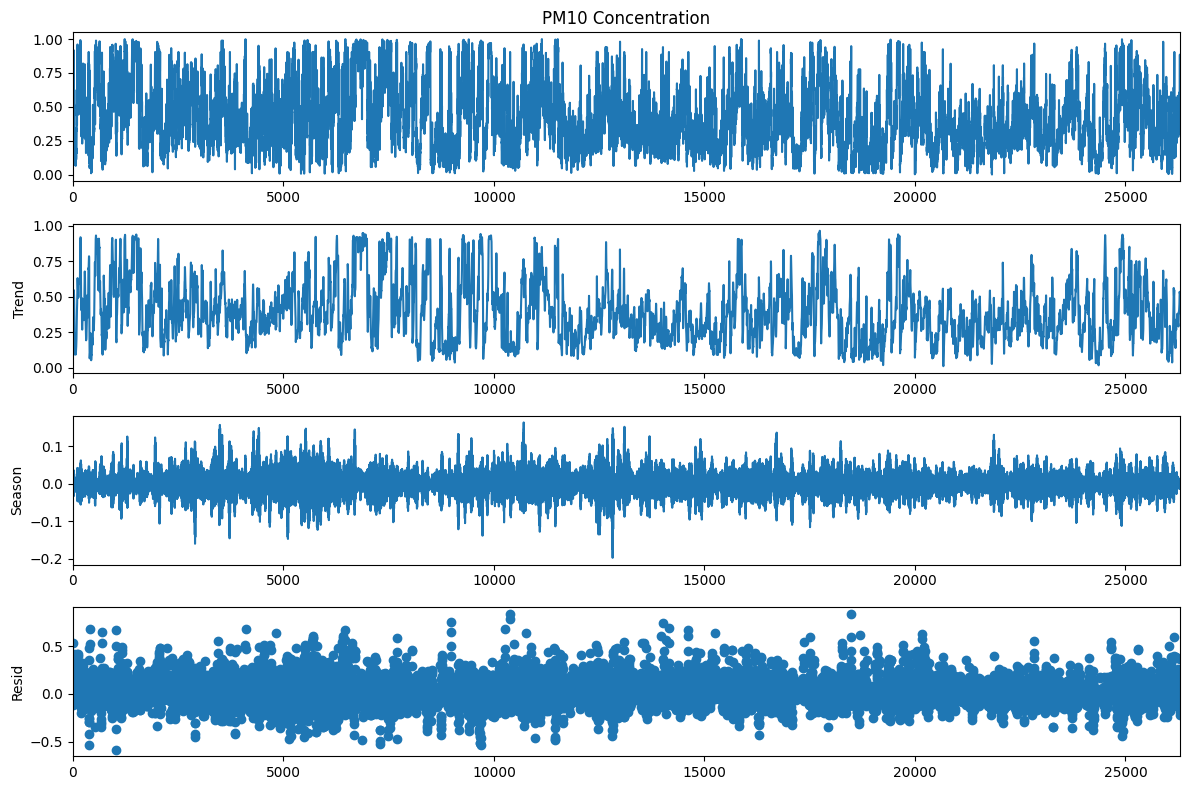

In [76]:
result_pm10 = STL(df['PM10 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_pm10.plot()
plt.show()
# data_cleaned = result.trend.reshape(-1, 1)

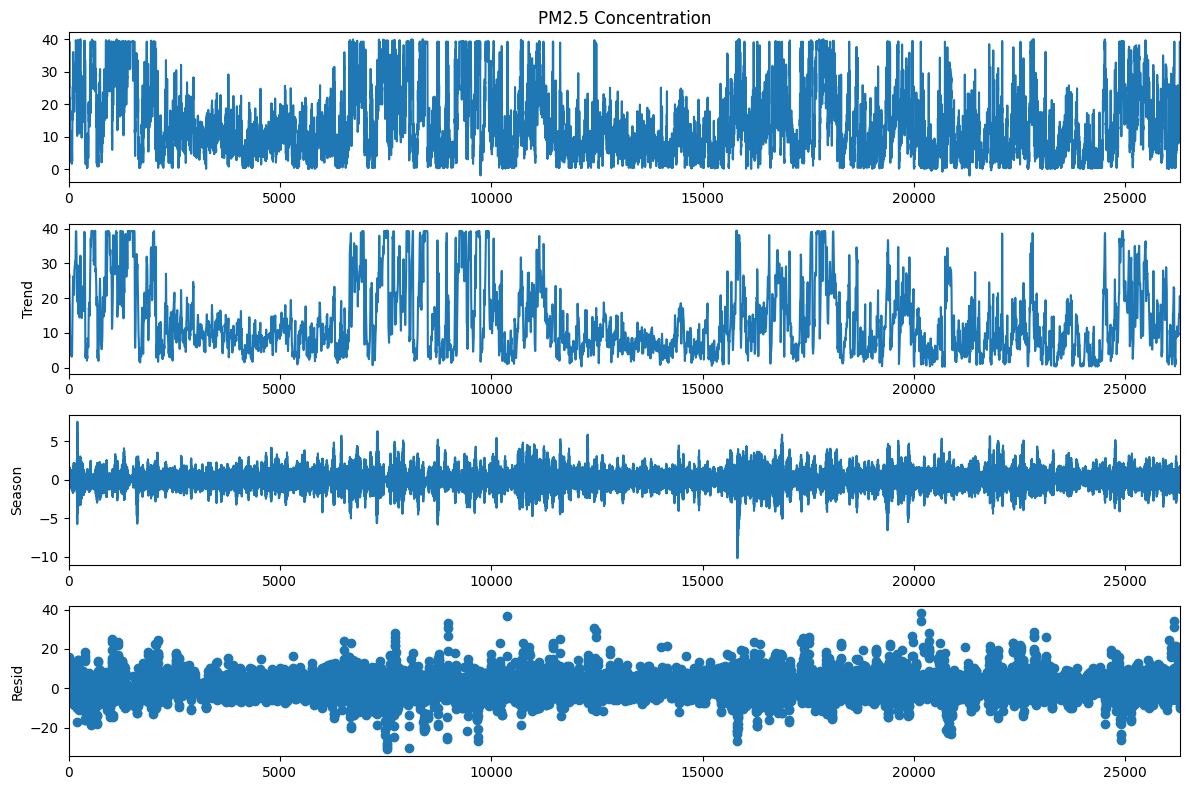

In [44]:
result_pm25 = STL(df['PM2.5 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_pm25.plot()
plt.show()

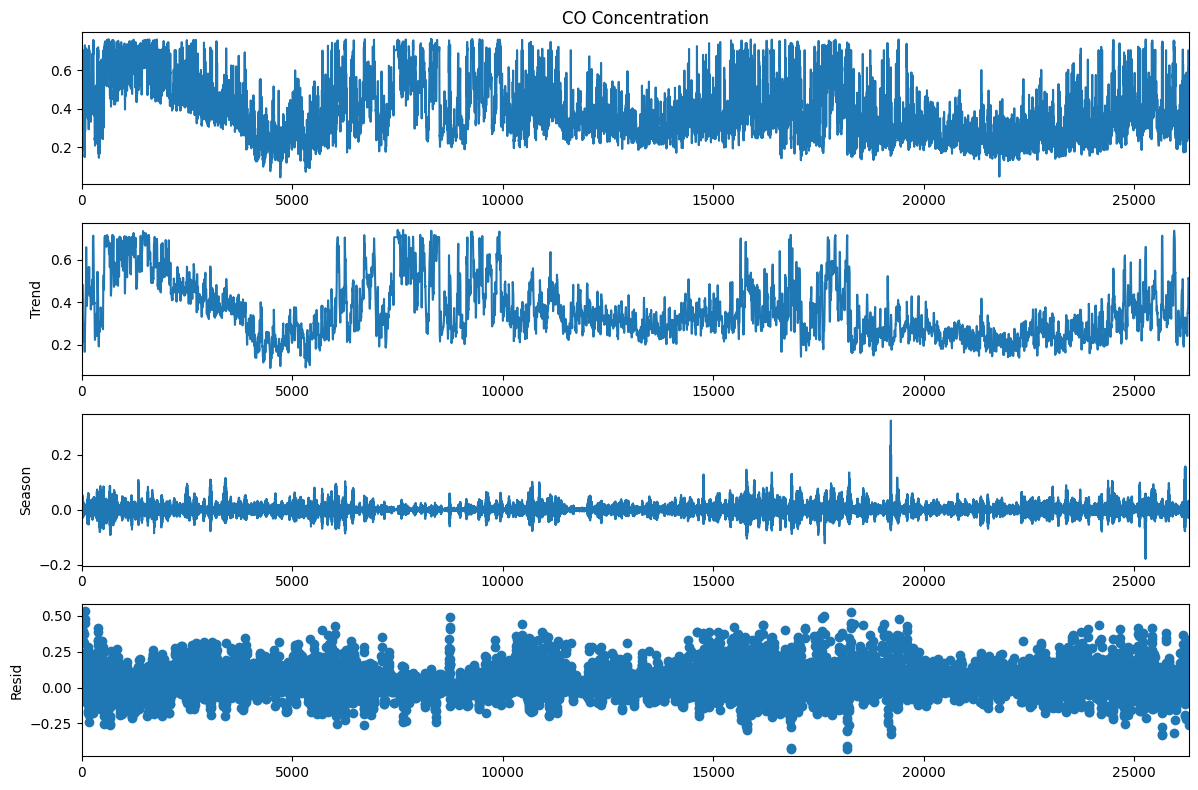

In [45]:
result_co = STL(df['CO Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_co.plot()
plt.show()

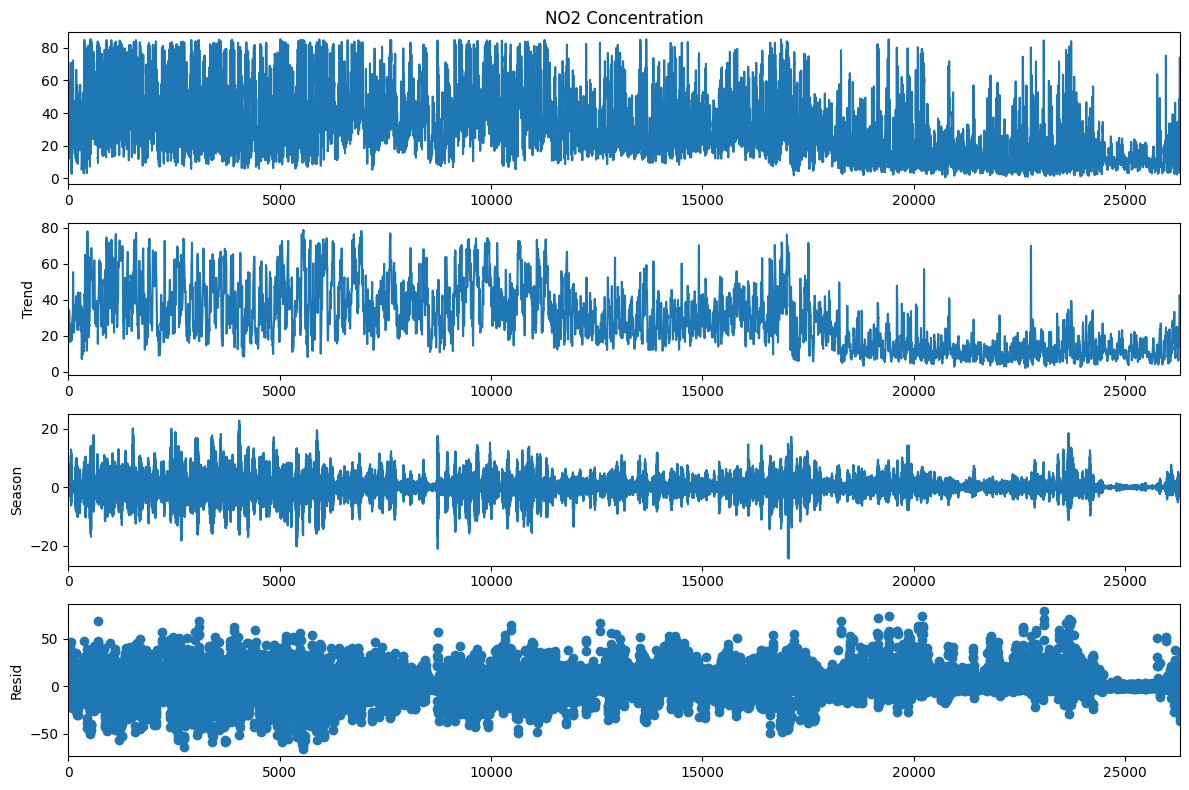

In [46]:
result_no2 = STL(df['NO2 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_no2.plot()
plt.show()

In [47]:
cleaned_training_df = pd.DataFrame({
    'PM10 Concentration': result_pm10.trend,
    'PM2.5 Concentration': result_pm25.trend,
    'CO Concentration': result_co.trend,
    'NO2 Concentration': result_no2.trend
})
cleaned_training_df.head()

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration
0,24.826430,26.019862,0.369766,17.614785
1,24.825447,25.984397,0.368732,17.589161
2,24.826101,25.945268,0.367640,17.559266
3,24.829847,25.904004,0.366451,17.520951
4,24.839355,25.865063,0.364913,17.467653


## Data scaling

In [48]:
scaler = MinMaxScaler()
df[:] = scaler.fit_transform(df)
cleaned_training_df[:] = scaler.transform(cleaned_training_df)

In [49]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM10 Concentration,26298.0,0.405300,0.226326,0.0,0.231904,0.368304,0.539191,1.0
PM2.5 Concentration,26298.0,0.378677,0.252380,0.0,0.187149,0.304852,0.512415,1.0
CO Concentration,26298.0,0.465336,0.204234,0.0,0.310145,0.418438,0.586151,1.0
NO2 Concentration,26298.0,0.359272,0.230473,0.0,0.173269,0.313889,0.503975,1.0


## Data windowing

In [50]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        self.train_set = train_df
        self.val_set = val_df
        self.test_set = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.create_dsets()

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}', f'Input indices: {self.input_indices}', f'Label indices: {self.label_indices}', f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds

    # @property
    def train(self):
        return self.make_dataset(self.train_set)

    # @property
    def val(self):
        return self.make_dataset(self.val_set)

    # @property
    def test(self):
        return self.make_dataset(self.test_set)

    def create_dsets(self):
        self.train = self.train()
        self.val = self.val()
        self.test = self.test()

    @property
    def example(self):
        result = getattr(self, '_example', None)
        result = next(iter(self.test))
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, max_subplots=4, training_data=False):
        inputs, labels = None, None
        if training_data:
            inputs, labels = next(iter(self.train))
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))
        print(len(inputs), len(labels))
        for n in range(max_n):
            plot_col = 'PM10 Concentration'
            if n == 2:
                plot_col = 'PM2.5 Concentration'
            elif n == 3:
                plot_col = 'CO Concentration'
            elif n == 4:
                plot_col = 'NO2 Concentration'
            plot_col_index = self.column_indices[plot_col]
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', zorder=-10, c='#2a7ab8')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            if label_col_index is None:
                continue

            if training_data:
                plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', zorder=-10, c='#42a7f5')
            else:
                plt.plot(self.label_indices, labels[n, :, label_col_index], label='Real Data', zorder=-10, c='#42a7f5')
            if model is not None:
                predictions = model(inputs)
                plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#0eb039')

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        # print(self.label_columns)

In [67]:
num_features = df.shape[1]
n = len(df)
# train = df[0:int(n*0.7)]
train = cleaned_training_df[0:int(n*0.7)]
val = df[int(n*0.7):int(n*0.9)]
test = df[int(n*0.9):]

dataWin = WindowGenerator(input_width=24*10, label_width=24*5, shift=24*5, train_df=train, val_df=val, test_df=test)

## Model creation and training

In [68]:
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(24*10, 4), return_sequences=True),
        # tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dropout(0.3),
        # tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(120*4, activation='relu'),
        tf.keras.layers.Reshape([24*5, num_features])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 240, 72)           22176     
                                                                 
 flatten_2 (Flatten)         (None, 17280)             0         
                                                                 
 dropout_2 (Dropout)         (None, 17280)             0         
                                                                 
 dense_2 (Dense)             (None, 480)               8294880   
                                                                 
 reshape_2 (Reshape)         (None, 120, 4)            0         
                                                                 
Total params: 8,317,056
Trainable params: 8,317,056
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(dataWin.train, epochs=15, callbacks=[early_stopping], shuffle=True)

Epoch 1/15
565/565 [==============================] - 65s 112ms/step - loss: 0.0294 - mean_absolute_error: 0.1298 - root_mean_squared_error: 0.1715 - mean_absolute_percentage_error: 41.1295
Epoch 2/15
565/565 [==============================] - 64s 113ms/step - loss: 0.0205 - mean_absolute_error: 0.1089 - root_mean_squared_error: 0.1432 - mean_absolute_percentage_error: 34.3293
Epoch 3/15
565/565 [==============================] - 61s 107ms/step - loss: 0.0156 - mean_absolute_error: 0.0955 - root_mean_squared_error: 0.1251 - mean_absolute_percentage_error: 29.7781
Epoch 4/15
565/565 [==============================] - 60s 107ms/step - loss: 0.0124 - mean_absolute_error: 0.0853 - root_mean_squared_error: 0.1115 - mean_absolute_percentage_error: 26.3390
Epoch 5/15
565/565 [==============================] - 61s 107ms/step - loss: 0.0107 - mean_absolute_error: 0.0796 - root_mean_squared_error: 0.1036 - mean_absolute_percentage_error: 24.5253
Epoch 6/15
565/565 [==============================

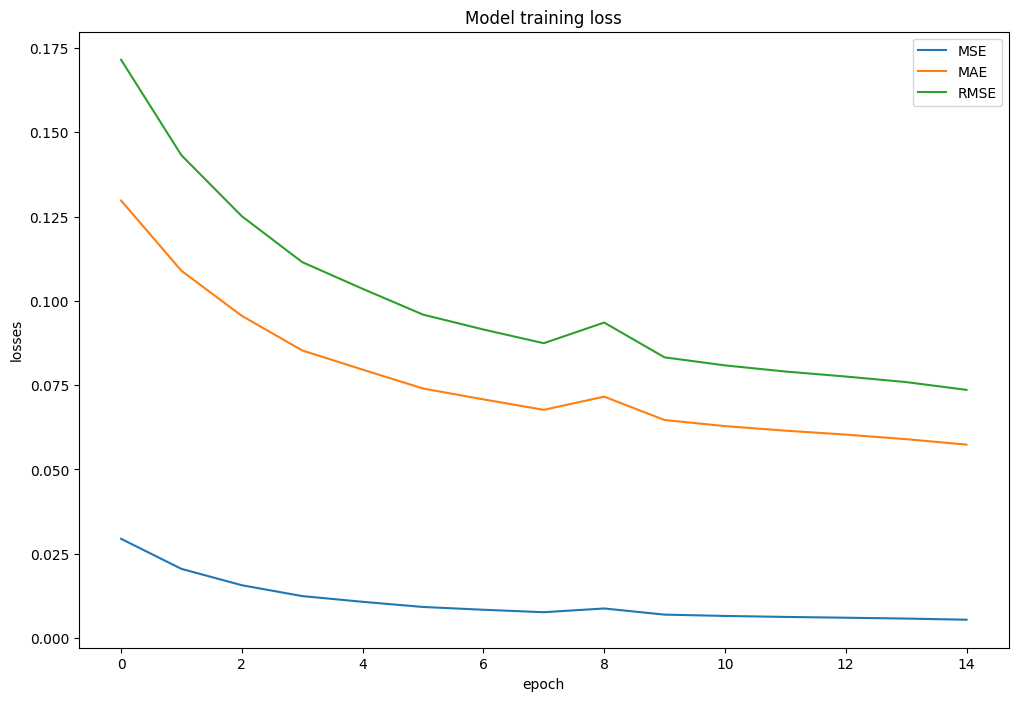

In [70]:
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Model training loss')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [71]:
eval_score = model.evaluate(dataWin.val)
print(f'MSE, MAE, RMSE, MAPE: {eval_score}')

154/154 [==============================] - 5s 28ms/step - loss: 0.0953 - mean_absolute_error: 0.2434 - root_mean_squared_error: 0.3088 - mean_absolute_percentage_error: 50679.7070
MSE, MAE, RMSE, MAPE: [0.09533395618200302, 0.2433834969997406, 0.30876192450523376, 50679.70703125]


32 32


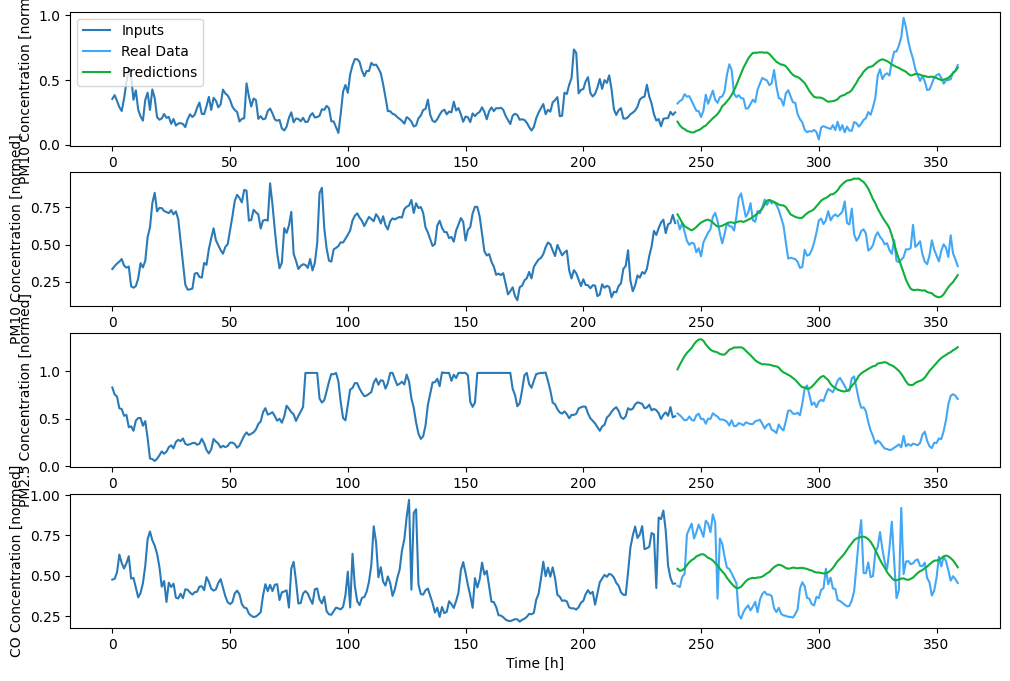

In [72]:
dataWin.plot(model)

32 32


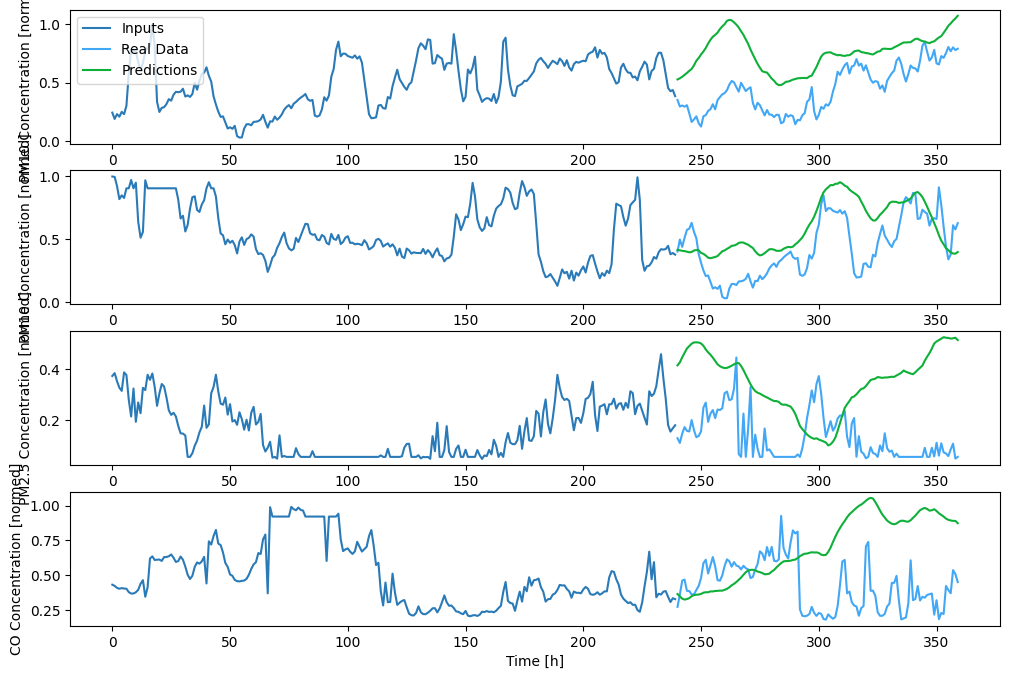

In [73]:
dataWin.plot(model)

32 32


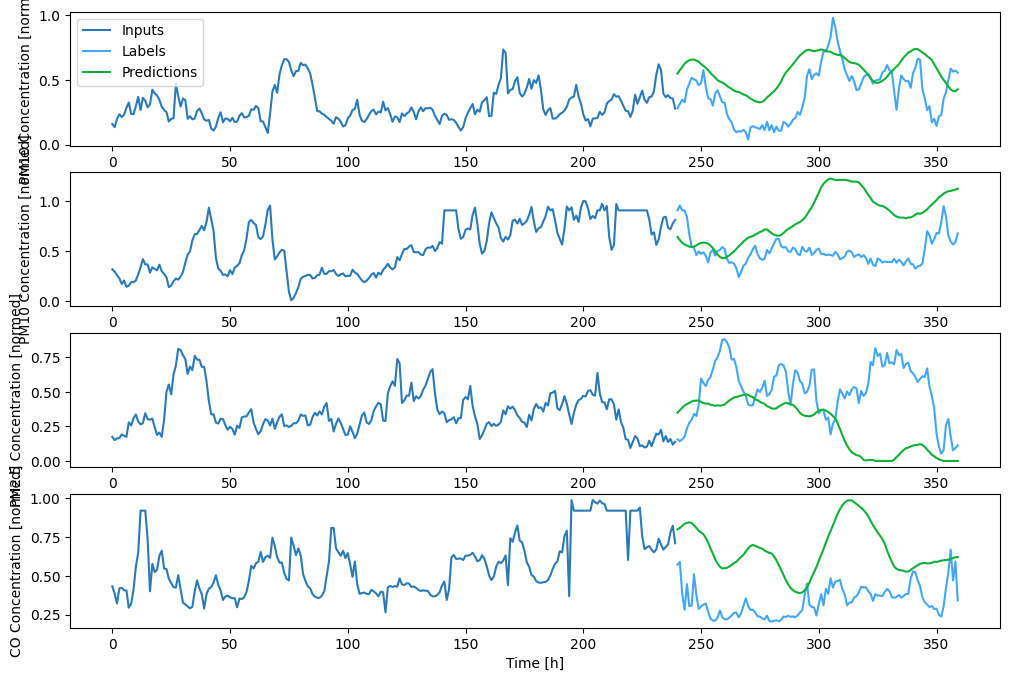

In [74]:
dataWin.plot(model, training_data=True)